# Travelling Salesman Problem

In [62]:
%matplotlib inline

In [39]:
from numpy import *
from random import *
from math import exp, log
from copy import deepcopy
from itertools import cycle
import matplotlib as matplotlib
import re

Definimos una solución como una permutación con su coste

In [40]:
class Route:
        
        def __init__(self, permutation, dist):
            self.permutation = deepcopy(array(permutation))
            self.dist = array(dist)
            self.update_cost()

        """Calculates cuadratic cost"""
        def update_cost(self):
            pairs = self.get_edges()
            self.cost = sum([self.dist[x,y] for (x,y) in pairs])
        
        def change_positions(self,i,j):
            # Intercambia dos ciudades del grafo
            self.permutation[i], self.permutation[j] = self.permutation[j], self.permutation[i]
            self.update_cost()
            
        def change_edges(self,i,j):
            # Intercambia dos aristas del grafo
            i,j = min(i,j), max(i,j)
            
            rev = self.permutation[i:j]
            rev = rev[::-1]
            self.permutation[i:j] = rev
            self.update_cost()
        
        def get_edges(self):
            shifted = append(self.permutation[1:], [self.permutation[0]])
            pairs = zip(self.permutation, shifted)
            return(pairs)
            

Implementación de la clase que albergará los datos del problema

In [164]:
class TSP:   
    
    #def prueba(self):
    #    return(Route(array(range(len(self.points))), self.dist))
    
    def __read (self, file):  
        f = open(file, 'r')
        match = '^[0-9].*'
        points = []
        
        for line in f:
            is_point = re.search(match, line)

            if is_point:
                x,y = map(float, line.split()[1:])
                points.append((x,y))
    
        return(points)
    
    
    def simulated_annealing(self, t_ini, max_iter, alpha, mu, phi):
        """Número de ciudades"""
        n = len(self.points)
        
        """Permutación"""
        permutation = array(range(n))
        shuffle(permutation)
        solution = Route(permutation, self.dist)
        best_solution = Route(permutation, self.dist)

        """Temperatura"""
        #t = t_ini
        t = (mu/-log(phi))*solution.cost        
        
        """Variables que controlan las iteraciones"""
        improvement = True
        i=0
        
        while i < max_iter:
            candidate = deepcopy(solution)
            
            # Generamos los índices de los arcos a cambiar
            u = randint(0, n-1)
            v = randint(u+1, n)   
            candidate.change_edges(u,v)
            
            """u = randint(0, n-1)
            v = randint(0, n-1)
            candidate.change_positions(u,v)"""
            
            diff_cost = candidate.cost - solution.cost
            
            if (diff_cost < 0 or random() < exp(-diff_cost*1.0/t)):
                solution = deepcopy(candidate)
        
                if (solution.cost < best_solution.cost):
                    best_solution = deepcopy(solution)
            
            """Esquema de enfriamiento"""
            t = alpha*t
            
            i+=1
        
        return best_solution
    
    def _make_permutation(self, edge_freq):
        edge_freq = array(edge_freq)
        n = len(edge_freq)
        prev = 0
        permutation = array([0]*n)
        visited = array([True] + [False]*(n-1))

        for i in range(1,n):
            min_freq = min_freq = float("inf")

            for j in where(visited == False)[0]:
                if not visited[j] and edge_freq[prev,j] < min_freq:
                    min_freq = edge_freq[prev,j]
                    selected = j

            visited[selected] = True
            prev = selected
            permutation[i] = prev

        return(permutation)
            
    
    
    def tabu_search(self, max_iter, max_vecinos, tabu_tenencia, aspiration_tol, limit_restart):
        """Número de ciudades"""
        n = len(self.points)
        
        """Permutación"""
        permutation = array(range(n))
        shuffle(permutation)
        neighbour = Route(permutation, self.dist)
        best_solution = deepcopy(neighbour)
        
        """Lista tabú de soluciones"""
        tabu_list = [None] * tabu_tenencia
        index = cycle(range(len(tabu_list)))
        restart = False
        
        """Lista de reinicialización"""
        non_improving = 0
        edge_freq = array([[0]*n]*n)
        i = 0
        
        
        while i < max_iter:                
            j = 0
            
            if restart:
                u = random()

                if (u < prob_bs):
                    neighbour = deepcopy(best_solution)
                else: 
                    neighbour = Route(self._make_permutation(edge_freq), self.dist)

                restart = False
                non_improving = 0                    
                    
            best_neighbour = deepcopy(neighbour)
            u_tabu, v_tabu = None, None

            
            while i< max_iter and j < max_vecinos and not restart:     
                # Generamos los índices de los arcos a cambiar
                candidate = deepcopy(neighbour)    
                u = randint(0, n-1)
                v = randint(u+1, n)   
                candidate.change_edges(u,v)
                
                eval_solution = True
                
                
                # Si hay arcos comunes entre ambos
                if (set([(u,v)]) & set(tabu_list)):
                    eval_solution = False
                    
                    """Criterio de aspiración"""
                    if candidate.cost < aspiration_tol*best_solution.cost:
                        eval_solution = True
                
                if eval_solution:
                    if candidate.cost < best_neighbour.cost:
                        best_neighbour = deepcopy(candidate)
                        u_tabu, v_tabu = u,v  

                        for (p,q) in best_neighbour.get_edges():
                            edge_freq[p,q] += 1;

                        if candidate.cost < best_solution.cost:
                            best_solution = deepcopy(candidate)                      
                            improvement = True
                    else:
                        non_improving += 1
                        restart = (non_improving == limit_restart)          
                  
                j+=1
                i+=1
            """Fin de exploración del vecindario"""
            
            
            neighbour = deepcopy(best_neighbour)
            # Arcos del mejor vecino
            if u_tabu is not None:
                tabu_list[ next(index) ] = (u_tabu, v_tabu)
            else:
                tabu_list[ next(index) ] = None
            
            
        """Fin de toda la exploración"""
        return best_solution
    
        
    def print_solution(self, solution):
        p_x = [ self.points[i][0] for i in solution.permutation ]
        p_y = [ self.points[i][1] for i in solution.permutation ]
        p_x = append(p_x, p_x[0])
        p_y = append(p_y, p_y[0])
        tol_x = 0.05 * mean(p_x)
        tol_y = 0.05 * mean(p_y)
        
        matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth':3})
        matplotlib.pyplot.figure(figsize=(15,10))
        matplotlib.pyplot.xlim(min(p_x) - tol_x, max(p_x) + tol_x)
        matplotlib.pyplot.ylim(min(p_y) - tol_y, max(p_y) + tol_y)
        matplotlib.pyplot.plot(p_x, p_y, marker='o', color='red', markersize=7)
    
    def __init__(self, file):
        self.points = array(self.__read(file))
        self.dist = sqrt(
            [
                [dot(subtract(x,y),subtract(x,y)) for x in self.points] 
                for y in self.points
            ])


In [179]:
files = ['berlin52.tsp', 'ch150.tsp', 'd198.tsp', 'eil101.tsp', 'rd400.tsp']
semillas = [12345, 23451, 34512, 45123, 51234] 
#semillas = [12345]

problems = {}
sa_solutions = {}
ts_solutions = {}
best_solutions = {'berlin52': 7542,
                  'ch150': 6528,
                  'd198': 15780,
                  'eil101': 629,
                  'rd400': 15281}
sa_costes = {'berlin52': 0.0,
          'ch150': 0.0,
          'd198': 0.0,
          'eil101': 0.0,
          'rd400': 0.0}
ts_costes = deepcopy(sa_costes)

In [ ]:
for f in files:
    name = f[:-4]
    problems[name] = TSP(f)
    size = len(problems[name].points)
    n_iter = size*100
    alpha = 0.95
    
    for s in semillas:
        seed(s)
        sa_solutions[name] = problems[name].simulated_annealing(size*1e3, n_iter, alpha, 0.05, 0.05) 
        sa_costes[name] += sa_solutions[name].cost
        
    sa_costes[name] /= len(semillas)

In [181]:
for f in files:
    seed(semilla)
    name = f[:-4]
    problems[name] = TSP(f)
    size = len(problems[name].points)
    n_iter = size*100
    aspiration_tol = 1.
    limit_restart = 25
    max_vecinos = 25
    tabu_tenencia=int(size*0.3)
    prob_bs = 0.95
    prob_greedy = 0.05

    for s in semillas:
        seed(s)
        ts_solutions[name] = problems[name].tabu_search(n_iter, max_vecinos, tabu_tenencia, aspiration_tol, limit_restart)
        ts_costes[name] += ts_solutions[name].cost
        
    ts_costes[name] /= len(semillas)
   

eil101
	 SA: 741.140168607
	 TS: 780.299292213
	 Best: 629
berlin52
	 SA: 8372.30083638
	 TS: 8236.33552506
	 Best: 7542
ch150
	 SA: 8910.60758943
	 TS: 9182.38585345
	 Best: 6528
d198
	 SA: 21051.1858543
	 TS: 18472.0637835
	 Best: 15780
rd400
	 SA: 27549.9619768
	 TS: 32000.2655374
	 Best: 15281


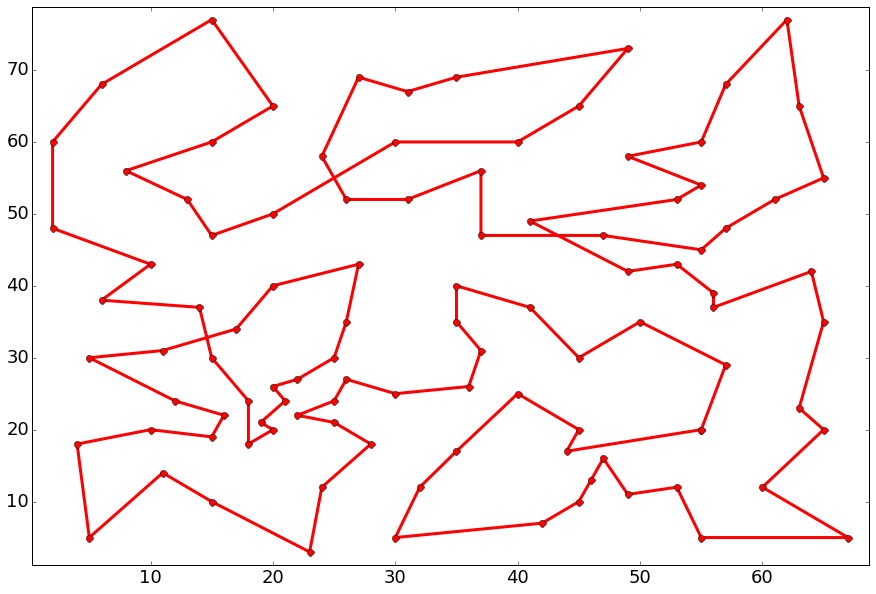

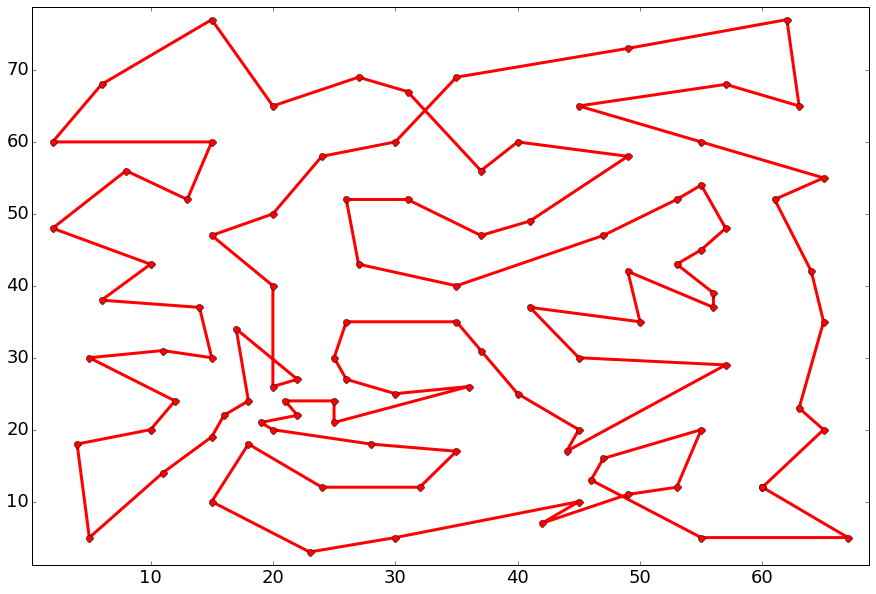

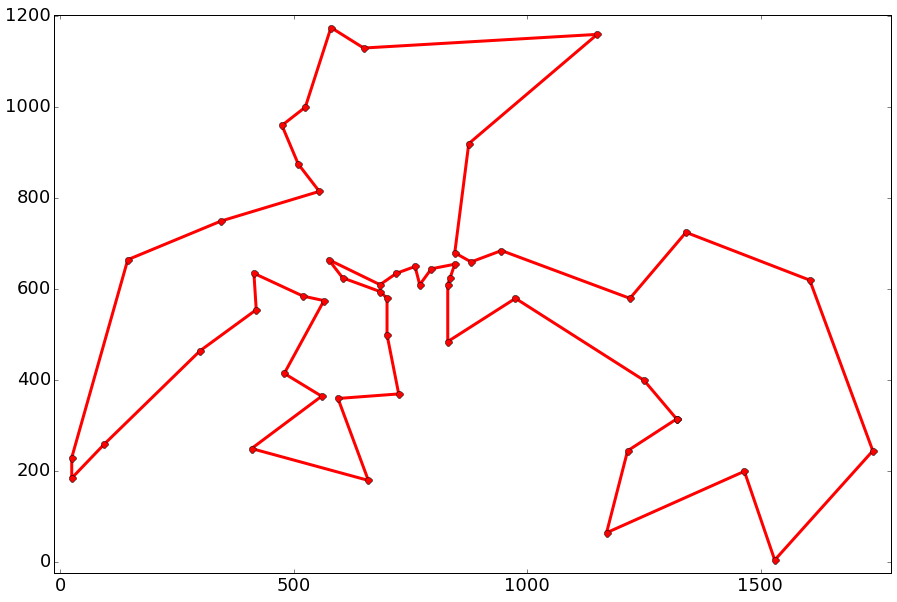

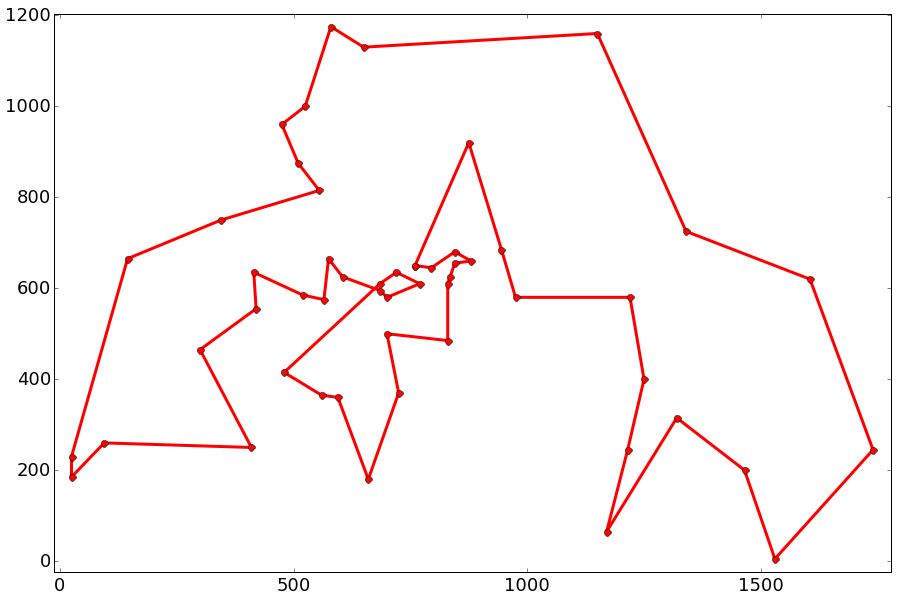

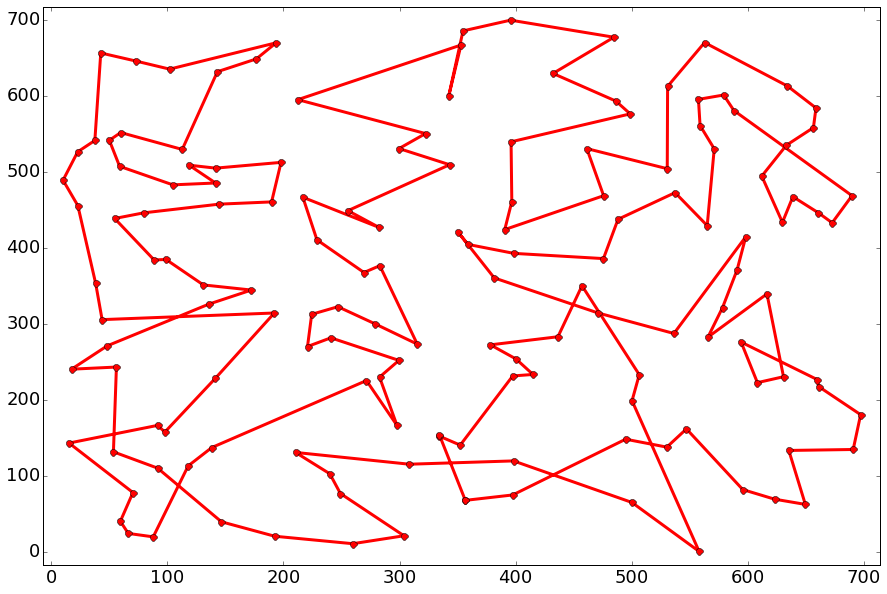

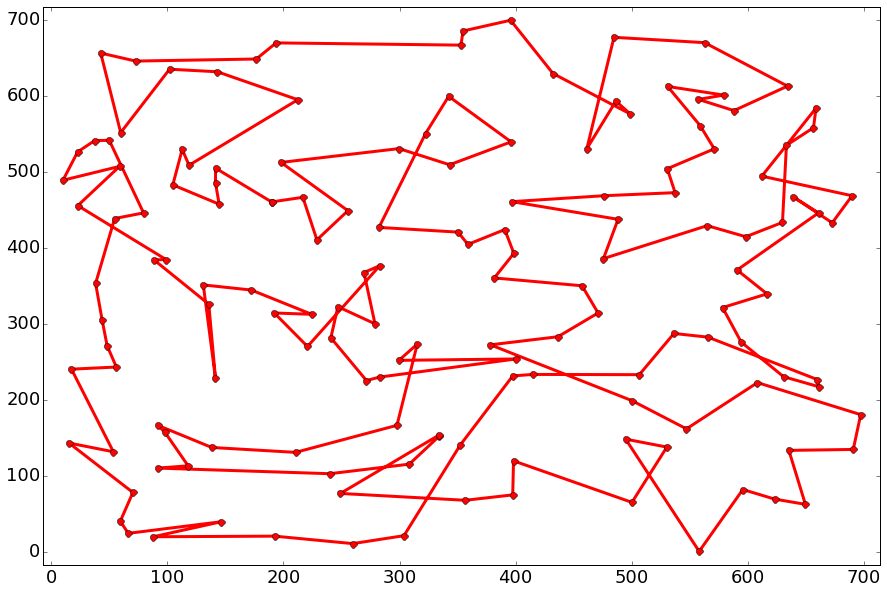

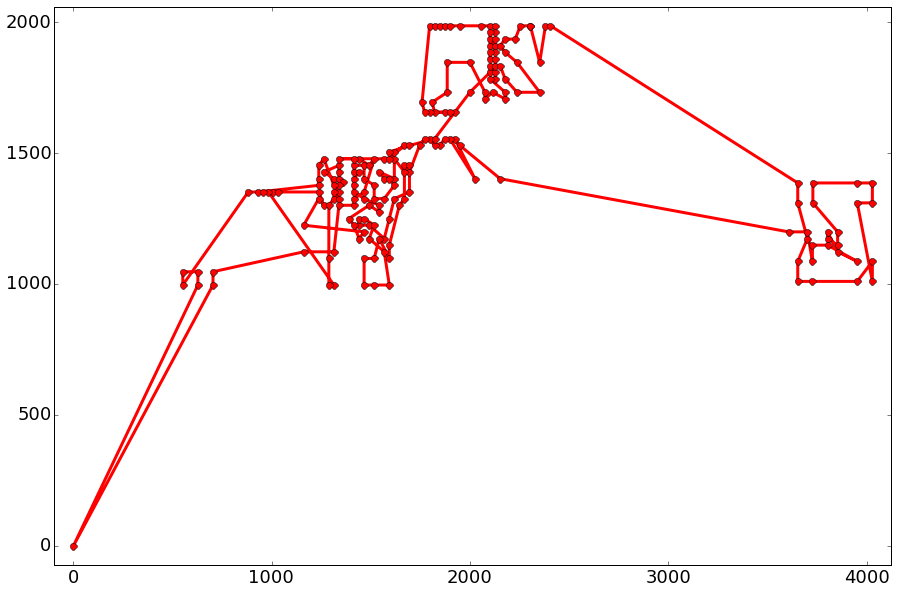

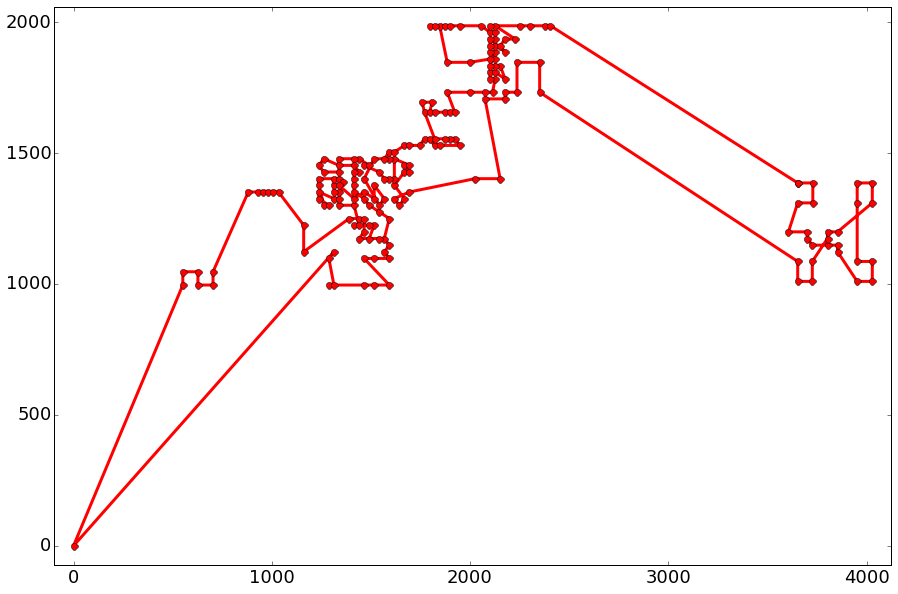

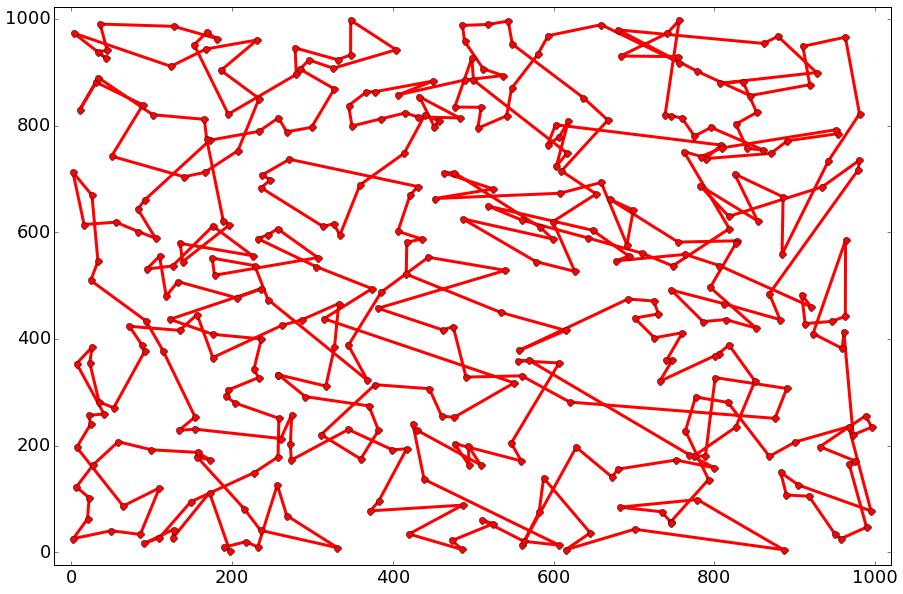

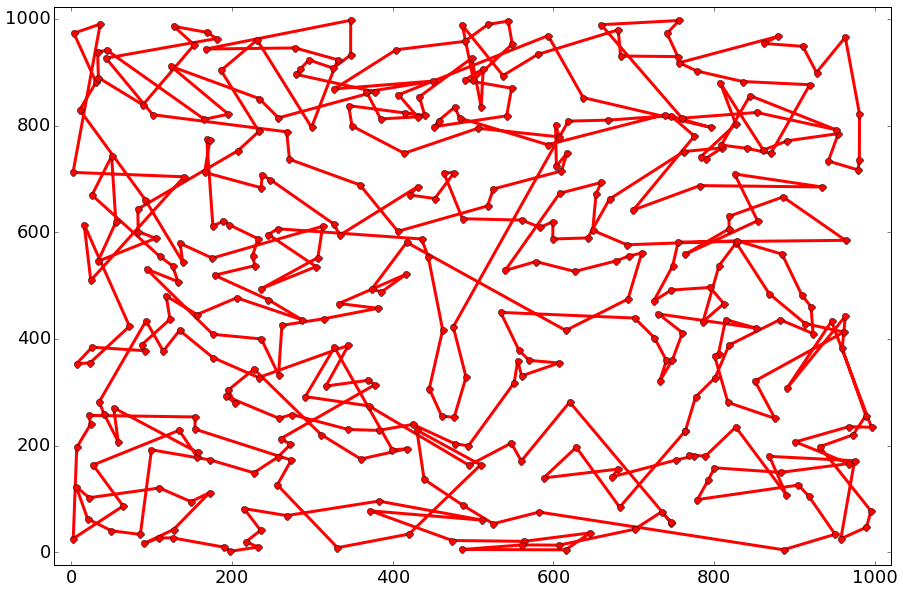

In [182]:
for name in problems:
    print (name 
           + '\n\t SA: '   + str(sa_costes[name])
           + '\n\t TS: '   + str(ts_costes[name])
           + '\n\t Best: ' + str(best_solutions[name]))
    problems[name].print_solution(sa_solutions[name])
    problems[name].print_solution(ts_solutions[name])